In [1]:
'''
TORCWA Example1
Rectangular meta-atom

'''
# Import
import numpy as np
import torch
from matplotlib import pyplot as plt
import scipy.io

import torcwa
import Materials

# Hardware
# If GPU support TF32 tensor core, the matmul operation is faster than FP32 but with less precision.
# If you need accurate operation, you have to disable the flag below.
torch.backends.cuda.matmul.allow_tf32 = False
sim_dtype = torch.complex64
geo_dtype = torch.float32
device = torch.device('cuda')

# Simulation environment
# light
inc_ang = 0.*(np.pi/180)    # radian
azi_ang = 0.*(np.pi/180)    # radian

# material
substrate_eps = 1.46**2

# geometry
L = [300., 300.]            # nm / nm
torcwa.rcwa_geo.dtype = geo_dtype
torcwa.rcwa_geo.device = device
torcwa.rcwa_geo.Lx = L[0]
torcwa.rcwa_geo.Ly = L[1]
torcwa.rcwa_geo.nx = 300
torcwa.rcwa_geo.ny = 300
torcwa.rcwa_geo.grid()
torcwa.rcwa_geo.edge_sharpness = 1000.
z = torch.linspace(-500,1500,501,device=device)

x_axis = torcwa.rcwa_geo.x.cpu()
y_axis = torcwa.rcwa_geo.y.cpu()
z_axis = z.cpu()

# layers
layer0_geometry = torcwa.rcwa_geo.rectangle(Wx=180.,Wy=100.,Cx=L[0]/2.,Cy=L[1]/2.)
layer0_thickness = 300.

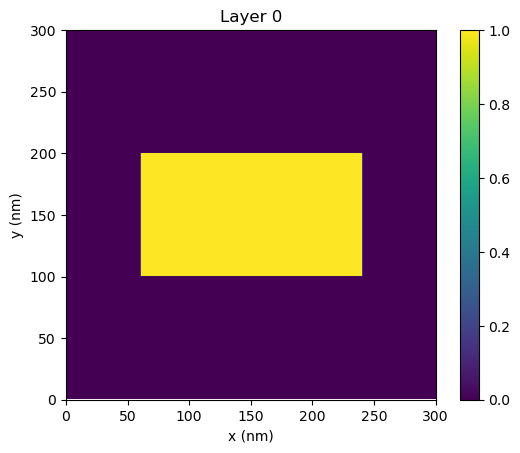

In [2]:
# View layers
plt.imshow(torch.transpose(layer0_geometry,-2,-1).cpu(),origin='lower',extent=[x_axis[0],x_axis[-1],y_axis[0],y_axis[-1]])
plt.title('Layer 0')
plt.xlim([0,L[0]])
plt.xlabel('x (nm)')
plt.ylim([0,L[1]])
plt.ylabel('y (nm)')
plt.colorbar()

In [3]:
# Generate and perform simulation
order_N = 15
order = [order_N,order_N]
lamb0 = torch.linspace(400.,700.,61,dtype=geo_dtype,device=device)

txx = []
for lamb0_ind in range(len(lamb0)):
    lamb0_now = lamb0[lamb0_ind]
    sim = torcwa.rcwa(freq=1/lamb0_now,order=order,L=L,dtype=sim_dtype,device=device)
    sim.add_input_layer(eps=substrate_eps)
    sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
    silicon_eps = Materials.aSiH.apply(lamb0_now)**2
    layer0_eps = layer0_geometry*silicon_eps + (1.-layer0_geometry)
    sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
    sim.solve_global_smatrix()
    txx.append(sim.S_parameters(orders=[0,0],direction='forward',port='transmission',polarization='xx',ref_order=[0,0]))
txx = torch.cat(txx)

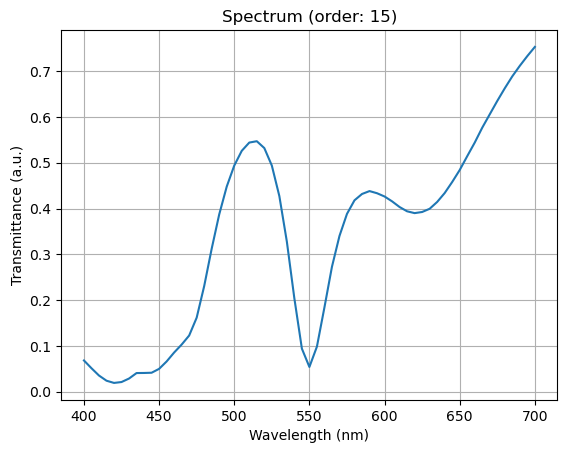

In [4]:
# View spectrum
plt.plot(lamb0.cpu(),torch.abs(txx).cpu()**2)
plt.title('Spectrum (order: '+str(order_N)+')')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmittance (a.u.)')
plt.grid()

In [5]:
# Export spectrum data
ex1_data = {'lamb0':lamb0.cpu().numpy(),'txx':txx.cpu().numpy()}
scipy.io.savemat('Example1_spectrum_data_order_'+str(order_N)+'.mat',ex1_data)

In [6]:
# Generate and perform simulation
lamb0 = torch.tensor(532.,dtype=geo_dtype,device=device)    # nm

order_N = 15
order = [order_N,order_N]
sim = torcwa.rcwa(freq=1/lamb0,order=order,L=L,dtype=sim_dtype,device=device)
sim.add_input_layer(eps=substrate_eps)
sim.set_incident_angle(inc_ang=inc_ang,azi_ang=azi_ang)
silicon_eps = Materials.aSiH.apply(lamb0)**2
layer0_eps = layer0_geometry*silicon_eps + (1.-layer0_geometry)
sim.add_layer(thickness=layer0_thickness,eps=layer0_eps)
sim.solve_global_smatrix()
sim.source_planewave(amplitude=[1.,0.],direction='forward')

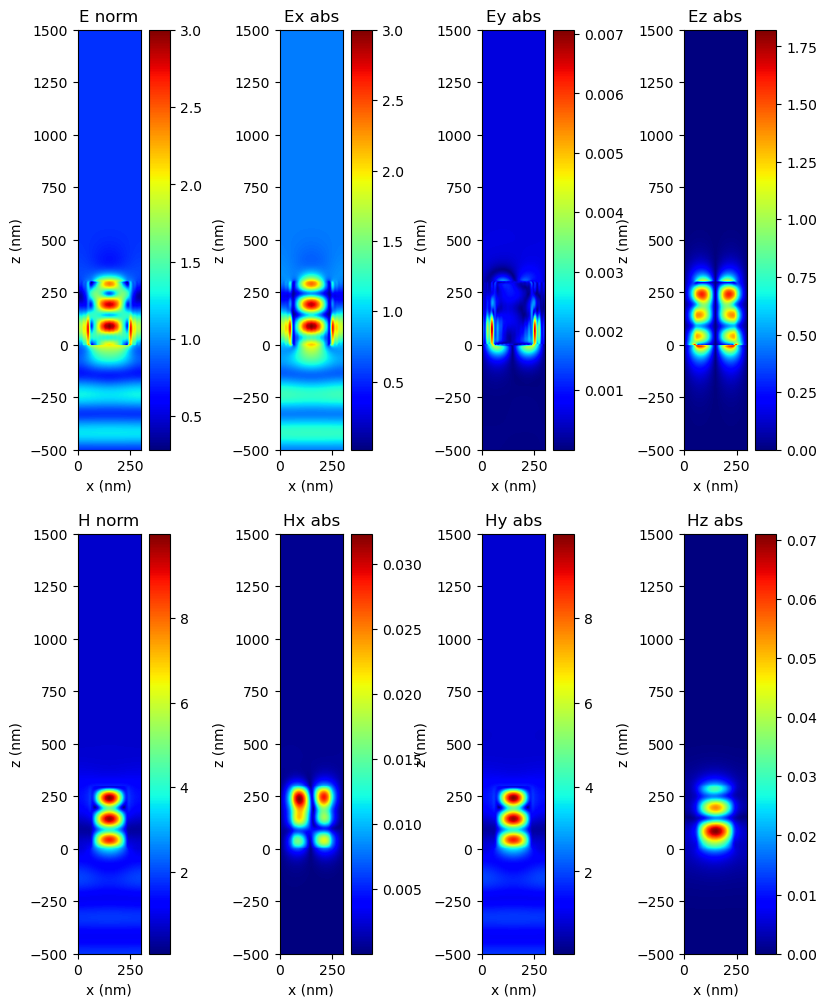

In [7]:
# View XZ-plane fields and export
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_xz(torcwa.rcwa_geo.x,z,L[1]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

fig, axes = plt.subplots(figsize=(10,12),nrows=2,ncols=4)
im0 = axes[0,0].imshow(torch.transpose(Enorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,0].set(title='E norm',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im1 = axes[0,1].imshow(torch.transpose(torch.abs(Ex),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,1].set(title='Ex abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im2 = axes[0,2].imshow(torch.transpose(torch.abs(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,2].set(title='Ey abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im3 = axes[0,3].imshow(torch.transpose(torch.abs(Ez),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[0,3].set(title='Ez abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im4 = axes[1,0].imshow(torch.transpose(Hnorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,0].set(title='H norm',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im5 = axes[1,1].imshow(torch.transpose(torch.abs(Hx),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,1].set(title='Hx abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im6 = axes[1,2].imshow(torch.transpose(torch.abs(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,2].set(title='Hy abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im7 = axes[1,3].imshow(torch.transpose(torch.abs(Hz),-2,-1).cpu(),cmap='jet',origin='lower',extent=[x_axis[0],x_axis[-1],z_axis[0],z_axis[-1]])
axes[1,3].set(title='Hz abs',xlim=(0,L[0]),xlabel='x (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
fig.colorbar(im0,ax=axes[0,0])
fig.colorbar(im1,ax=axes[0,1])
fig.colorbar(im2,ax=axes[0,2])
fig.colorbar(im3,ax=axes[0,3])
fig.colorbar(im4,ax=axes[1,0])
fig.colorbar(im5,ax=axes[1,1])
fig.colorbar(im6,ax=axes[1,2])
fig.colorbar(im7,ax=axes[1,3])

ex1_XZ_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('Example1_XZ_data.mat',ex1_XZ_data)

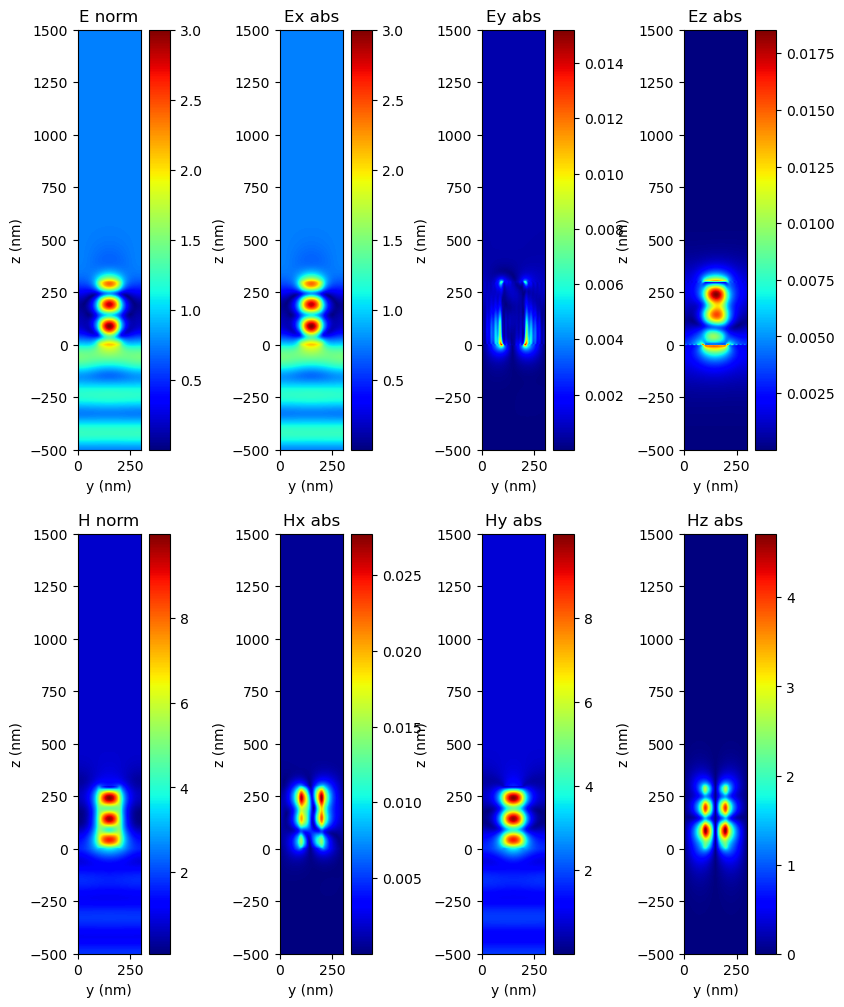

In [8]:
# View YZ-plane fields and export
[Ex, Ey, Ez], [Hx, Hy, Hz] = sim.field_yz(torcwa.rcwa_geo.y,z,L[0]/2)
Enorm = torch.sqrt(torch.abs(Ex)**2 + torch.abs(Ey)**2 + torch.abs(Ez)**2)
Hnorm = torch.sqrt(torch.abs(Hx)**2 + torch.abs(Hy)**2 + torch.abs(Hz)**2)

fig, axes = plt.subplots(figsize=(10,12),nrows=2,ncols=4)
im0 = axes[0,0].imshow(torch.transpose(Enorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[0,0].set(title='E norm',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im1 = axes[0,1].imshow(torch.transpose(torch.abs(Ex),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[0,1].set(title='Ex abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im2 = axes[0,2].imshow(torch.transpose(torch.abs(Ey),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[0,2].set(title='Ey abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im3 = axes[0,3].imshow(torch.transpose(torch.abs(Ez),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[0,3].set(title='Ez abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im4 = axes[1,0].imshow(torch.transpose(Hnorm,-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[1,0].set(title='H norm',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im5 = axes[1,1].imshow(torch.transpose(torch.abs(Hx),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[1,1].set(title='Hx abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im6 = axes[1,2].imshow(torch.transpose(torch.abs(Hy),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[1,2].set(title='Hy abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
im7 = axes[1,3].imshow(torch.transpose(torch.abs(Hz),-2,-1).cpu(),cmap='jet',origin='lower',extent=[y_axis[0],y_axis[-1],z_axis[0],z_axis[-1]])
axes[1,3].set(title='Hz abs',xlim=(0,L[0]),xlabel='y (nm)',ylim=(z_axis[0],z_axis[-1]),ylabel='z (nm)')
fig.colorbar(im0,ax=axes[0,0])
fig.colorbar(im1,ax=axes[0,1])
fig.colorbar(im2,ax=axes[0,2])
fig.colorbar(im3,ax=axes[0,3])
fig.colorbar(im4,ax=axes[1,0])
fig.colorbar(im5,ax=axes[1,1])
fig.colorbar(im6,ax=axes[1,2])
fig.colorbar(im7,ax=axes[1,3])

ex1_YZ_data = {'x_axis':x_axis.numpy(),'y_axis':y_axis.numpy(),'z_axis':z_axis.numpy(),\
    'Ex':Ex.cpu().numpy(),'Ey':Ey.cpu().numpy(),'Ez':Ez.cpu().numpy(),'Enorm':Enorm.cpu().numpy(),\
    'Hx':Hx.cpu().numpy(),'Hy':Hy.cpu().numpy(),'Hz':Hz.cpu().numpy(),'Hnorm':Hnorm.cpu().numpy()}
scipy.io.savemat('Example1_YZ_data.mat',ex1_YZ_data)